In [155]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
import os, sys
sys.path.append('..')
from maps import *
from glob import glob
import json
from utils import *
import numpy as np
from IPython.display import Image
from dataset import *
from tqdm import tqdm
tqdm.monitor_interval = 0
from models.Variants import *
from forecast import *

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [165]:
glist = '../data/subset.txt'
# glist = '../data/subset.txt'
with open(glist) as fl:
    glist = fl.read().split('\n')
print(len(glist))

# GPATH = '../data/graphs_random/'
# CPATH = '/home/ubuntu/datasets-aux/checkpoints/old'

GPATH = '../data/graphs/'
CPATH = '/home/ubuntu/datasets-aux/checkpoints/checkpoints'

47


In [179]:
wfiles = glob('%s/mpfcast/*_n5.pth' % CPATH)
gfiles = glob('%s/*_n5.json' % GPATH)
assert len(wfiles)
# print(len(gfiles))
segname = lambda fname: fname[:-5].split('/')[-1].split('_n')[0]
gfiles = [fname for fname in gfiles if segname(fname) in glist]
gfiles = [fname for fname in gfiles if ('%s/mpfcast/%s_n5.pth' % (CPATH, segname(fname))) in wfiles]
# print(len(gfiles))
assert len(gfiles)

subset = gfiles
graphs = [read_graph(fname, named_adj=True, verbose=False) for fname in subset]
assert len(graphs) is len(gfiles)
len(gfiles)

45

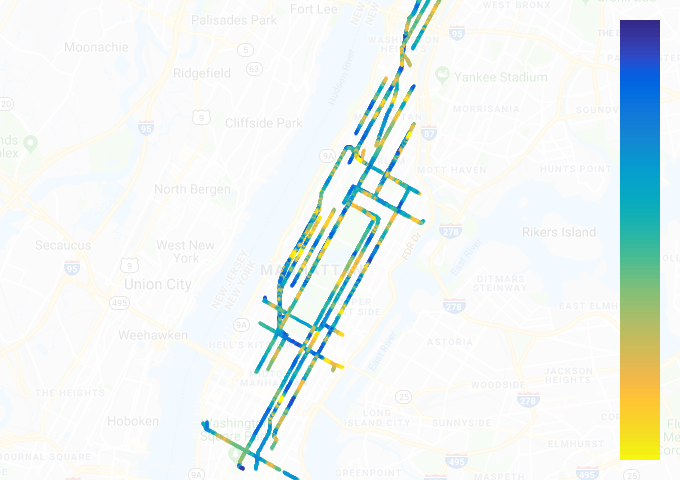

In [180]:
randSpeed = lambda : np.random.randint(0, 25)
speedToIntensity = lambda spd: 1 - min(1, spd / 25)
ints = [{ vert: speedToIntensity(randSpeed()) for vert in vs } for vs, _ in graphs]
# ints = [{ vert: speedToIntensity(0) for vert in vs } for vs, _ in graphs]
assert len(ints) is len(graphs)

map_graph('full', graphs, ints, border=False, zoom=12, wait=3, opacity=0.85)

Image(filename='full.png') 

In [181]:
test_data = []
for vs, adj in tqdm(graphs):
    tset = SpotHistory(vs, 'test', 4, lag=None, shuffle=False, clip_hours=0, verbose=False)
    test_data.append(tset)




  0%|          | 0/45 [00:00<?, ?it/s]


  2%|▏         | 1/45 [00:01<01:21,  1.85s/it]


  4%|▍         | 2/45 [00:03<01:17,  1.80s/it]


  7%|▋         | 3/45 [00:05<01:17,  1.85s/it]


  9%|▉         | 4/45 [00:07<01:15,  1.84s/it]


 11%|█         | 5/45 [00:09<01:13,  1.83s/it]


 13%|█▎        | 6/45 [00:10<01:10,  1.81s/it]


 16%|█▌        | 7/45 [00:12<01:08,  1.80s/it]


 18%|█▊        | 8/45 [00:14<01:06,  1.79s/it]


 20%|██        | 9/45 [00:15<01:03,  1.78s/it]


 22%|██▏       | 10/45 [00:17<01:01,  1.76s/it]


 24%|██▍       | 11/45 [00:19<00:59,  1.76s/it]


 27%|██▋       | 12/45 [00:21<00:57,  1.75s/it]


 29%|██▉       | 13/45 [00:22<00:56,  1.75s/it]


 31%|███       | 14/45 [00:24<00:54,  1.77s/it]


 33%|███▎      | 15/45 [00:26<00:52,  1.76s/it]


 36%|███▌      | 16/45 [00:28<00:50,  1.75s/it]


 38%|███▊      | 17/45 [00:29<00:49,  1.75s/it]


 40%|████      | 18/45 [00:31<00:47,  1.75s/it]


 42%|████▏     | 19/45 [00:33<00:45,  1.74s/it]


 44%|████▍     

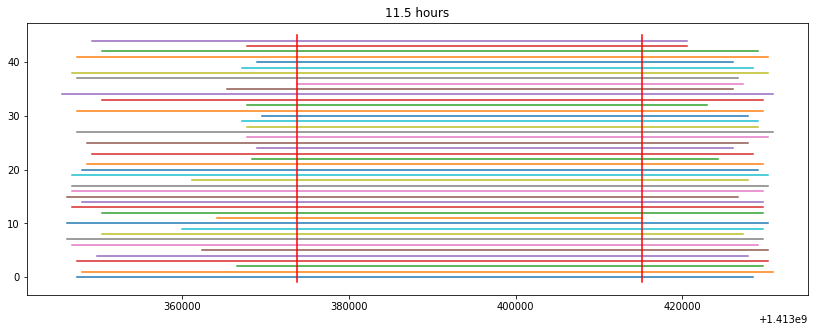

In [182]:
import time
import matplotlib.pyplot as plt
d2s = lambda date: time.mktime(date.timetuple())
# from utils import *

# for day in range(1, 5):
DAY = 2
plt.figure(figsize=(14, 5))
tmin, tmax = None, None
for di, dset in enumerate(test_data):
    t0, tf = map(d2s, dset.trange[DAY])
    seqlen = dset[DAY].shape[0]
    tsteps = int((tf - t0) / 60 / 10) + 1
    assert tsteps is seqlen
    
    plt.plot([t0, tf], [di, di])
    if tmin is None or t0 > tmin:
        tmin = t0
    if tmax is None or tf < tmax:
        tmax = tf
window = (tmax - tmin) / 60 / 60
plt.title('%.1f hours' % window)
plt.plot([tmin, tmin], [-1, len(test_data)], color='red')
plt.plot([tmax, tmax], [-1, len(test_data)], color='red')
plt.show(); plt.close()

In [207]:
seqlen = int((tmax - tmin) / 60 / 10)
print('Parallel available:', seqlen)
parallel = []
for di, dset in enumerate(test_data):
    t0, tf = dset.trange[DAY]
    dt = tmin - d2s(t0)
    pos0 = int(dt / 60 / 10)
    
    availset = dset[DAY][pos0:pos0+seqlen-1]
#     print(pos0, seqlen, dset[DAY].shape, availset.shape)
    parallel.append(availset)

Parallel available: 69


In [184]:
def load_mprnn(vs, adj, hops, wpath):
    model = MPRNN_FCAST(
        nodes=vs, adj=adj, 
        iters=3,
        iter_indep=False,
        hidden_size=128, 
        verbose=False)

    model.to(device)
    model.device = device
    model.hops = hops
    model.load(wpath=wpath, verbose=False)
    return model

In [221]:
TIME = 5
graph_speeds = { ti: list() for ti in range(TIME, TIME+20)}
true_speeds = { ti: list() for ti in range(TIME, TIME+20)}
for gi, (graph_file, (vs, adj), tseries) in enumerate(zip(gfiles, graphs, parallel)):
#     print(graph_file)
    seg = segname(graph_file)
    mprnn = load_mprnn(vs, adj, 3, '%s/mpfcast/%s_n5.pth' % (CPATH, seg))
    
    sqerr, datamat = forecast_mprnn(
                tseries, mprnn, graph_file, 
                twoway=True,
                verbose=False, plot=False)
#     print(tseries.shape)
#     print()
    
    
    print(tseries.shape)
    for ti in range(TIME, TIME+20):
        predicted = {}
        truevals = {}
        for vi, vert in enumerate(vs):
            speed_hat = datamat[vert][ti]
            predicted[vert] = speed_hat
            truevals[vert] = tseries[ti+1][vi] * 10 + 12 # next value offset
        graph_speeds[ti].append(predicted)
        true_speeds[ti].append(truevals)
    
    sys.stdout.write('[%d/%d]: %s    \r' % (gi, len(gfiles), graph_file))
    sys.stdout.flush()
    
assert len(graph_speeds) is len(true_speeds)

(68, 11)
(68, 11)../data/graphs/401259-401261_n5.json    
(68, 13)../data/graphs/400044-400045_n5.json    


KeyboardInterrupt: 

In [219]:
for ti in tqdm(range(TIME, TIME+5)):
    speedToIntensity = lambda spd: 1 - min(1, spd / 25)
    graph_ints = [
        {vert:speedToIntensity(vel) for vert, vel in byvert.items()} 
        for byvert in graph_speeds[ti]]
    true_ints = [
        {vert:speedToIntensity(vel) for vert, vel in byvert.items()} 
        for byvert in true_speeds[ti]]
    
    diff_ints = [
        {vert: abs(speedToIntensity(vel) - speedToIntensity(ytrue[vert]))
         for vert, vel in yhat.items()} 
            for yhat, ytrue in zip(graph_speeds[ti], true_speeds[ti])]
    
    map_graph('images/diff_%d' % ti, graphs, diff_ints, border=False, zoom=12, wait=3, opacity=0.85)
    map_graph('images/yhat_%d' % ti, graphs, graph_ints, border=False, zoom=12, wait=3, opacity=0.85)
    map_graph('images/true_%d' % ti, graphs, true_ints, border=False, zoom=12, wait=3, opacity=0.85)
#     break
# Image(filename='yhat.png') 






  0%|          | 0/5 [00:00<?, ?it/s]




 20%|██        | 1/5 [00:16<01:06, 16.75s/it]




 40%|████      | 2/5 [00:33<00:50, 16.72s/it]




 60%|██████    | 3/5 [00:49<00:33, 16.53s/it]




 80%|████████  | 4/5 [01:05<00:16, 16.44s/it]




100%|██████████| 5/5 [01:22<00:00, 16.41s/it]






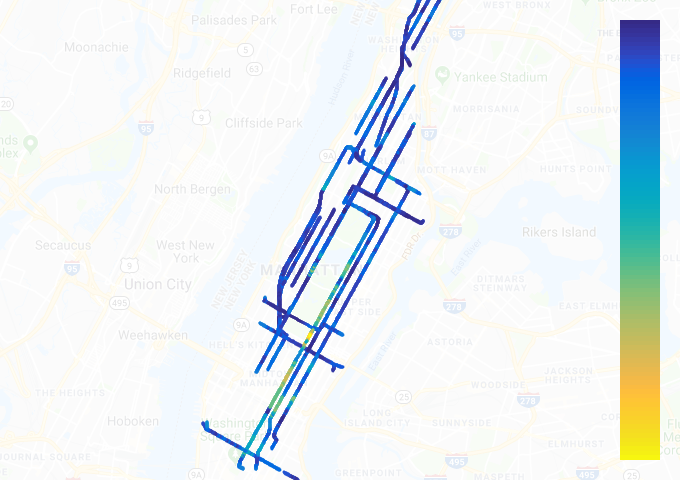

In [220]:
Image(filename='images/diff_9.png') 

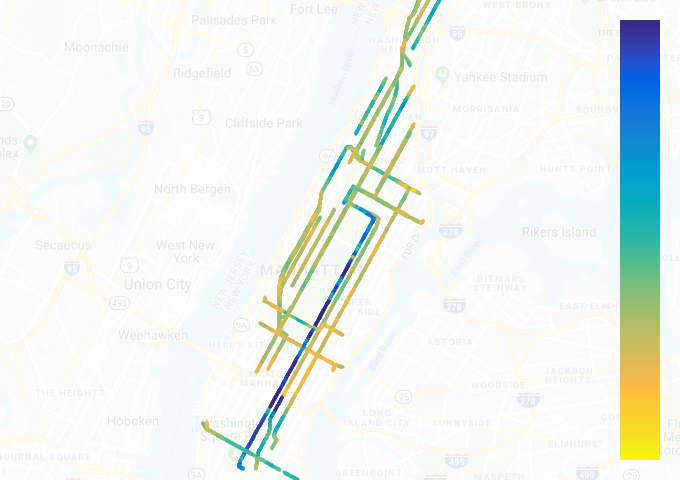

In [222]:
Image(filename='images/true_5.png') 

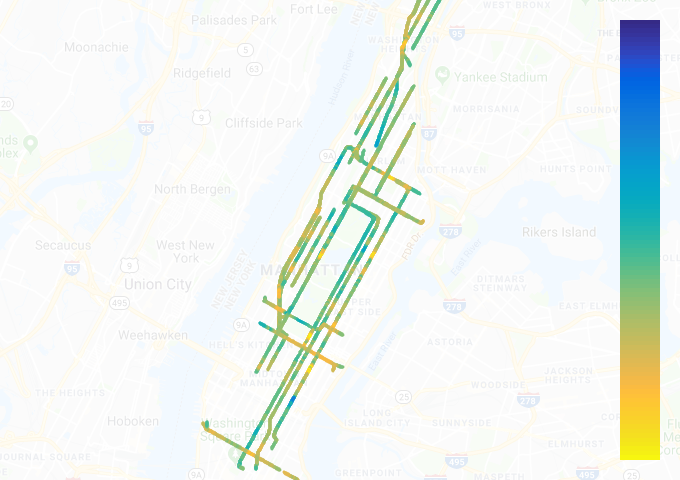

In [223]:
Image(filename='images/yhat_5.png') 

In [225]:
imgs = [cv2.imread('images/yhat_%d.png' % ii) for ii in range(5, 9)]
len(imgs)

4

In [ ]:
rows = []
for ii in range(0, len(imgs), 2):
    